### Определение темы по постам группы вк

Будем собирать посты из группы "Лентач" во вконтакте с целью выявить тематику группы. Рассмотрим также на какие кластеры тем можно разбить посты.

In [379]:
from time import time
import logging
import sys
import requests
import json
import datetime
from ast import literal_eval
import pandas as pd
import numpy as np
import configparser
import re
import nltk
from nltk.corpus import stopwords 
# from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
# lemma = WordNetLemmatizer()

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to /Users/mary/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Сбор информации. 



In [2]:
def gather_process():

    # gather data and save as txt
    id_ = 'lentach'
    owner_id = '29534144'# lentach
    count = 40
    offset = -1

    # In access_token.ini we have token for vk
    config = configparser.ConfigParser()
    config.read('access_token.ini')
    access_token = config.get('settings', 'token')
    
    for _ in range(100):
        url = 'https://api.vk.com/method/wall.get?owner_id=-{}&count={}&offset={}&v=5.52&access_token={}'.format(
            owner_id, count, offset + 1, access_token)
        respond = requests.get(url)
        with open(id_ + str(_) + '.txt', 'w') as outfile:
            json.dump(respond.json(), outfile)
        
        offset += count

In [3]:
def convert_data_to_table_format():
    
    # transform gathered data from txt file to pandas DataFrame and save as csv
    id_ = 'lentach'
    
    for _ in range(40):
        file = id_ + str(_) + '.txt'
        result = literal_eval(open(file, 'r').read())
        ids = []
        dates = []
        comments = []
        likes = []
        reposts = []
        text = []

        for item in result['response']['items']:
            ids.append(item['id'])
            dates.append(datetime.datetime.fromtimestamp(item['date']))
            comments.append(item['comments']['count'])
            likes.append(item['likes']['count'])
            reposts.append(item['reposts']['count'])
            text.append(item['text'].encode('utf-16', 'surrogatepass').decode('utf-16'))

        df = pd.DataFrame({
            "id": ids,
            "date": dates,
            "comments_count": comments,
            "likes_count": likes,
            "reposts_count": reposts,
            "text": text,
        })
        df.to_csv(id_ + str(_) + '.csv', sep='\t')
    
    pass



In [4]:
# Take latest 4 000 posts of lentach
# gather_process()

In [5]:
# Convert to csv
convert_data_to_table_format()

In [101]:
# Create 1 df from 40 files
df = pd.concat([pd.read_csv(r'lentach' + str(i) + '.csv', sep='\t') for i in range(40)], axis=0)
df.shape

(4000, 7)

In [102]:
df[98:103]

,Unnamed: 0,id,date,comments_count,likes_count,reposts_count,text
98,98,11435352,2019-07-02 12:35:12,133,2793,11,Чехия сняла ограничения на полёты российских а...
99,99,11434988,2019-07-02 11:35:06,198,8598,204,В декабре 2018 года студент ВГИКа Артём Фирсан...
0,0,11434891,2019-07-02 11:20:00,43,373,6,• «Интерфакс»: число жертв паводка в Иркутской...
1,1,11434549,2019-07-02 10:36:15,199,5763,78,"Цены на свинину, говядину и мясо птицы в Росси..."
2,2,11434254,2019-07-02 09:34:23,288,1718,15,Сегодня утром власти Чехии запретили «Аэрофлот...


In [103]:
df = df.set_index('id')
df = df.drop(['Unnamed: 0'], axis=1)

In [104]:
df.head()

,date,comments_count,likes_count,reposts_count,text
id,,,,,
11460130,2019-07-06 16:13:03,92,1146,15,Список «ремейки фильмов с женщинами в главной ...
11459911,2019-07-06 15:33:47,155,1803,31,В России планируется своя «Википедия».\n\nПрав...
11459474,2019-07-06 14:17:03,168,6437,231,"А вы тоже в детстве двигали мышкой по экрану, ..."
11459119,2019-07-06 13:23:59,130,4821,141,Уже десять лет каждую первую субботу июля росс...
11458585,2019-07-06 12:11:06,681,5606,81,Основатель Amazon Джефф Безос официально развё...


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 11460130 to 10386610
Data columns (total 5 columns):
date              4000 non-null object
comments_count    4000 non-null int64
likes_count       4000 non-null int64
reposts_count     4000 non-null int64
text              3864 non-null object
dtypes: int64(3), object(2)
memory usage: 187.5+ KB


### 2. Обработка. 

* Удалим пропуски в значениях текста, т.к. никакая их обработка не поможет нашей цели
* Удалим русские стоп слова и знаки переноса строки (очистим текст)
* Разобьем каждый из текстов на отдельные слова
* Приведем слова к нормальной форме


In [106]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3864 entries, 11460130 to 10386610
Data columns (total 5 columns):
date              3864 non-null object
comments_count    3864 non-null int64
likes_count       3864 non-null int64
reposts_count     3864 non-null int64
text              3864 non-null object
dtypes: int64(3), object(2)
memory usage: 181.1+ KB


Первым делом (1) добавим в перечень стоп слов те, что не несут особой смысловой нагрузки

In [364]:
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'ows',
                   'который', 'это', 'один', 'главный', 'свой', 'такой', 'лентач', 'ещё', 'еще', 'самый', 'тот', 'пока', 
                   'мол', 'некоторый', 'почему', 'отдельный', 'год', 'неделя', 'сегодня', 'впервые', 'будущий', 'оно',
                  'сразу', 'затем', 'этот', 'также', 'жаль', 'сейчас', 'поэтому', 'лаифкаха', 'ввод', 'вывод', 'broco', 
                   'утро', 'последний', 'то', 'ничто', 'весь', 'стать', 'она', 'дать', 'хороший', 'весь', 'новый', 'имя', 'oqib',
                   'день', 'хотеть', 'большой', 'наш', 'узнать', 'очень', 'сделаться', 'просто', 'час', 'минута',
                   'назад', 'сюда', 'увеличиться', 'отдельный', 'полностью', 'перестать', 'иметь', 'owyt', 'проходить', 
                   'июль', 'сделать', 'делать', 'читать', 'писать', 'число', 'считать', 'каждый', 'ряд', 'начало', 'конец', 
                   'пикчер', 'ваш', 'любой', 'снова', 'сколько', 'club', 'например', 'лишь', 'целый', 'начать', 
                   'получить', 'com', 'кстати', 'вместо', 'watch', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь', 'восемь', 
                   'девять', 'десять','третье', 'мем', 'мема', 'слово', 'пара', 'январь', 'сегодня', 'суббота', 'ждать',
                   'ru', 'часто', 'тема', 'название', 'вокруг', 'oiahd', 'никто',  'остаться', 'сотня', 'сказать', 
                   'называть', 
                   'предложение', 'представить', 'собираться', 'предложение', 'около', 'нужно', 'сильно', 'вокруг', 'март', 
                   'именно', 
                   'отправить', 'получать', 'бывший', 'вчера', 'май', 'апрель', 'несколько', 'продолжать',
                   'взять', 'пройтись', 'использовать', 'почитать', 'вообще', 'рассказать', 'оказаться', 'rowp', 'ro', 'rrzf', 
                   'никак', 'хотя', 'rreq', 'grace', 'three','ropr', 'практически', 'rrg', 'rofm'
                  ])
stop_words = set(stop_words)

In [365]:
def clean(text):
    # Remove garbage from lines
    text = re.sub(r'\n', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'•', '', text, flags=re.IGNORECASE)
    text = text.replace('ё','е')
    return text


def doc_to_words(doc, stop_words, morph):
    # remove stop words and punctuation + lemmatize
    words = [morph.parse(w)[0].normal_form for w in gensim.utils.simple_preprocess(str(doc), deacc=False) \
             if morph.parse(w)[0].normal_form not in stop_words]
    
#     # make lemmatization
#     words = [morph.parse(w)[0].normal_form for w in words if morph.parse(w)[0].normal_form not in stop_words]
    
    return words

In [366]:
# Clean and split by words

morph = pymorphy2.MorphAnalyzer()

data = df.text.values.tolist()
data = [clean(t) for t in data]
data_words = [doc_to_words(text, stop_words, morph) for text in data]

In [367]:
print(data[0])
print(data_words[0])

Список «ремейки фильмов с женщинами в главной роли» может пополниться еще одной картиной.  На этот раз в лучших традициях последних лет планируют переснять ту самую «Маску» с Джимом Кэрри  http://news.lenta.ch/Ow21
['список', 'ремейка', 'фильм', 'женщина', 'роль', 'мочь', 'пополниться', 'картина', 'традиция', 'последний', 'планировать', 'переснять', 'маска', 'джим', 'кэрри']


### 3. Построение моделей

* Найдем биграммы слов в каждом тексте
* Занумеруем биграммы (добавив им id) и посчитаем сколько раз то или иное слово встречалось внутри каждого текста (сделаем корпус)
* Попробуем разбить тексты на несколько тематик: построим зависимость когерентности от количества тематик; оптимальное число отобразим
* 

In [368]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=1, delimiter=b' ') # higher threshold fewer phrases.

bigram_mod = gensim.models.phrases.Phraser(bigram)    
data_words_bigrams = [bigram_mod[w] for w in data_words]

In [369]:
data_words_bigrams[100:110]

[['утром',
  'власть',
  'чехия',
  'запретить',
  'аэрофлот',
  'победа',
  'уральский',
  'авиалиния',
  'полёт',
  'страна',
  'источник',
  'интерфакс',
  'сообщить',
  'вина',
  'недовольство',
  'прага',
  'условие',
  'транссибирский',
  'маршрут',
  'чешский',
  'национальный',
  'перевозчик',
  'поздний',
  'руководитель',
  'уральский',
  'авиалиния',
  'сообщить',
  'авиакомпания',
  'возобновить',
  'полёт',
  'екатеринбург',
  'прага',
  'oq'],
 ['отмечаться всемирный',
  'нло',
  'уфолог',
  'случай',
  'принести',
  'текст',
  'амбициозный',
  'попытка',
  'человечество',
  'сконструировать',
  'летать',
  'тарелка'],
 ['право',
  'качнуть',
  'мочь',
  'качнуть',
  'качка',
  'включить',
  'губернатор',
  'красноярский край',
  'александр',
  'усс',
  'жительница',
  'затопить',
  'город',
  'спросить',
  'видеть',
  'местный',
  'дорога',
  'размыть',
  'yp',
  'tc'],
 ['soundgarden',
  'американский рок',
  'группа',
  'сиэтл',
  'образовать',
  'родоначальник',
  'ст

In [370]:
id2word = corpora.Dictionary(data_words_bigrams) # token to id (add ids to tokens)
corpus = [id2word.doc2bow(text) for text in data_words_bigrams] # create (token_id, token_count): 2-tuples

In [371]:
print(corpus[2])
print(id2word[67])

[(25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 2), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 5), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 4), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 3), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 3), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1)]
скорость


In [372]:
# data[2].count('фоновый')

In [373]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Далее (2) построим график значений когерентности для разного количества тем

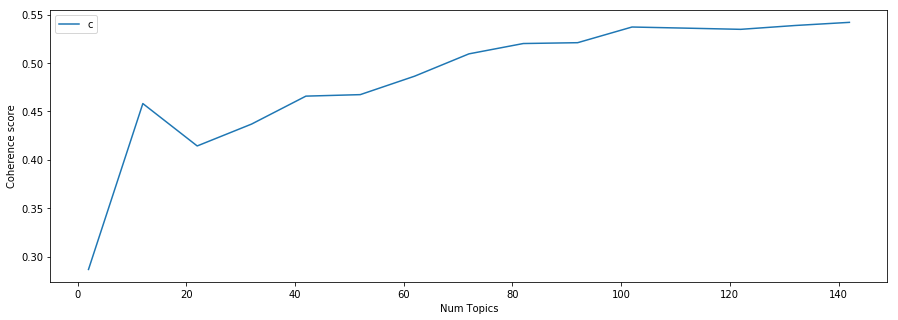

2:  0.2867482296429241
12:  0.4580420654809227
22:  0.41427259230931585
32:  0.43684789417050707
42:  0.4657167529796818
52:  0.4672630259111919
62:  0.48631461529190434
72:  0.5093758131353545
82:  0.5200404876276353
92:  0.520903605726719
102:  0.5370908828872726
112:  0.5359161107197111
122:  0.5346947556920667
132:  0.5386555060613682
142:  0.5419046638553985


In [374]:
limit=150; start=2; step=10;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

Теперь (3) построим модель LDA для приблизительно найденного количества тем и посмотрим на слова, описывающие темы

In [375]:
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=100, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');
pprint(lda_model.print_topics()) 

[(54,
  '0.000*"тренировка" + 0.000*"бегать" + 0.000*"барнаульский" + '
  '0.000*"постгранж" + 0.000*"подвести" + 0.000*"тёплый" + 0.000*"размещать" + '
  '0.000*"веганство" + 0.000*"оренбург" + 0.000*"visa"'),
 (51,
  '0.114*"церковь" + 0.091*"век" + 0.075*"рэпер" + 0.028*"драка" + '
  '0.015*"курганский" + 0.005*"физический" + 0.000*"телекомпания" + '
  '0.000*"размещать" + 0.000*"приверженец" + 0.000*"подвести"'),
 (55,
  '0.195*"месяц" + 0.088*"вырасти" + 0.062*"курс" + 0.037*"полтора" + '
  '0.029*"вдвое" + 0.016*"криптовалюта" + 0.000*"подвести" + '
  '0.000*"тренировка" + 0.000*"барнаульский" + 0.000*"постгранж"'),
 (89,
  '0.129*"смерть" + 0.092*"прислать" + 0.071*"парень" + 0.028*"беспорядок" + '
  '0.026*"темнокожий" + 0.022*"цвета" + 0.021*"застрелить" + 0.019*"израиль" + '
  '0.016*"кожа" + 0.008*"стычка"'),
 (5,
  '0.117*"идти" + 0.115*"угроза" + 0.048*"богоматерь" + 0.041*"собор '
  'парижский" + 0.041*"обрушение" + 0.025*"чрезвычайный" + 0.024*"говориться" '
  '+ 0.017*"

In [376]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -47.12075567050988

Coherence Score:  0.42252175935503056


Видим по графику когерентности, что с ростом количества тем когерентность растет, но на плато пока не выходит. По словам, описывающим темы, видим, что требуется дальнейшая очистка, поэтому переходим вновь к пункту 1: (1)добавим в стопслова новые термы (последние 4 строки - новые) и снова построим график (2) и модель с описывающими словами (3)

In [377]:
t=time()
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'ows',
                   'который', 'это', 'один', 'главный', 'свой', 'такой', 'лентач', 'ещё', 'еще', 'самый', 'тот', 'пока', 
                   'мол', 'некоторый', 'почему', 'отдельный', 'год', 'неделя', 'сегодня', 'впервые', 'будущий', 'оно',
                  'сразу', 'затем', 'этот', 'также', 'жаль', 'сейчас', 'поэтому', 'лаифкаха', 'ввод', 'вывод', 'broco', 
                   'утро', 'последний', 'то', 'ничто', 'весь', 'стать', 'она', 'дать', 'хороший', 'весь', 'новый', 'имя', 
                   'oqib', 'день', 'хотеть', 'большой', 'наш', 'узнать', 'очень', 'сделаться', 'просто', 'час', 'минута',
                   'назад', 'сюда', 'увеличиться', 'отдельный', 'полностью', 'перестать', 'иметь', 'owyt', 'проходить', 
                   'июль', 'сделать', 'делать', 'читать', 'писать', 'число', 'считать', 'каждый', 'ряд', 'начало', 'конец', 
                   'пикчер', 'ваш', 'любой', 'снова', 'сколько', 'club', 'например', 'лишь', 'целый', 'начать', 
                   'получить', 'com', 'кстати', 'вместо', 'watch', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь',
                    'восемь', 'девять', 'десять','третье', 'мем', 'мема', 'слово', 'пара', 'январь', 'сегодня', 'суббота', 
                   'ждать', 'ru', 'часто', 'тема', 'название', 'вокруг', 'oiahd', 'никто',  'остаться', 'сотня', 'сказать', 
                   'называть', 'предложение', 'представить', 'собираться', 'предложение', 'около', 'нужно', 'сильно', 'вокруг',
                   'именно', 'отправить', 'получать', 'бывший', 'вчера', 'май', 'апрель', 'несколько', 'продолжать', 'март', 
                   'взять', 'пройтись', 'использовать', 'почитать', 'вообще', 'рассказать', 'оказаться', 'rowp', 'ro', 'rrzf', 
                   'никак', 'хотя', 'rreq', 'grace', 'three','ropr', 'практически', 'rrg', 'rofm',
                   'вдвое', 'полтора', 'говориться', 'месяц', 'вечером', 'известный', 'начинать', 'основать', 'слишком',
                   'подвести', 'идти', 'принести', 'distemper', 'внезапно', 'наиболее', 'известный', 'качество', 'являться',
                   'обнаружить', 'in', 'напомнить', 'образовать', 'интересный', 'составить', 'насколько', 'появиться', 'давать',
                   'новое', 'новость', 'найти', 'давно', 'готовый'
                  ])
stop_words = set(stop_words)

morph = pymorphy2.MorphAnalyzer()

data = df.text.values.tolist()
data = [clean(t) for t in data]
data_words = [doc_to_words(text, stop_words, morph) for text in data]

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=1, delimiter=b' ') 
bigram_mod = gensim.models.phrases.Phraser(bigram)    
data_words_bigrams = [bigram_mod[w] for w in data_words]

id2word = corpora.Dictionary(data_words_bigrams) # token to id (add ids to tokens)
corpus = [id2word.doc2bow(text) for text in data_words_bigrams] # create (token_id, token_count): 2-tuples
print('Time to prepare words: {} mins'.format(round((time() - t) / 60, 2)))

Time to count coherence values: 21.54 mins


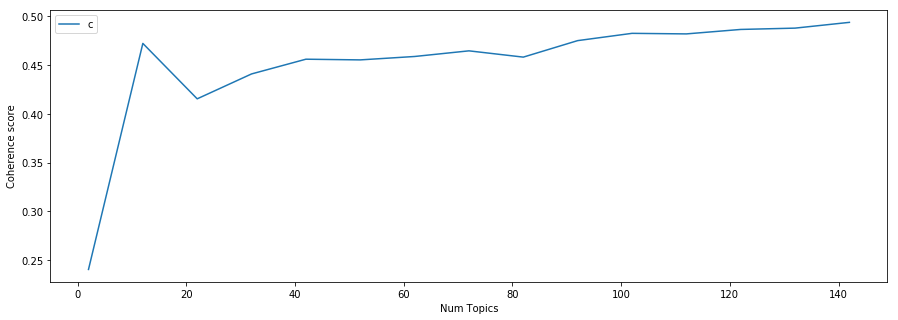

2:  0.24035816645686164
12:  0.4722596952969001
22:  0.4154016261100946
32:  0.44093446191127056
42:  0.45605012670331846
52:  0.45534506824289334
62:  0.458837505564166
72:  0.4646223200375851
82:  0.45818732530360196
92:  0.47511276404925995
102:  0.4825779186969424
112:  0.4820041751392451
122:  0.4865823482285866
132:  0.4879286877808433
142:  0.49385302891566646


In [380]:
limit=150; start=2; step=10;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

In [381]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=40, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');
print('Time to build model: {} mins'.format(round((time() - t) / 60, 2)))
pprint(lda_model.print_topics())

Time to build model: 1.45 mins
[(13,
  '0.082*"игра" + 0.061*"связь" + 0.058*"пользователь" + 0.035*"пенсионер" + '
  '0.031*"стоить" + 0.027*"состояние" + 0.024*"выделить" + 0.023*"ответ" + '
  '0.020*"лечение" + 0.017*"применение"'),
 (33,
  '0.035*"опрос" + 0.032*"возраст" + 0.023*"спикер" + 0.022*"связанный" + '
  '0.021*"совет федерация" + 0.021*"беларусь" + 0.020*"запрещать" + '
  '0.020*"пенсионный" + 0.019*"форма" + 0.018*"кажется"'),
 (24,
  '0.036*"серия" + 0.036*"огонь" + 0.031*"рунет" + 0.027*"париж" + '
  '0.021*"кража" + 0.020*"зимний" + 0.019*"край" + 0.017*"человек погибнуть" + '
  '0.016*"отдел" + 0.014*"текст"'),
 (35,
  '0.094*"запретить" + 0.050*"количество" + 0.035*"оштрафовать" + '
  '0.033*"европа" + 0.032*"google" + 0.021*"ошибка" + 0.020*"одежда" + '
  '0.020*"росгвардия" + 0.018*"транспорт" + 0.018*"протокол"'),
 (30,
  '0.062*"выпустить" + 0.040*"радиолентач" + 0.037*"собака" + 0.034*"завод" + '
  '0.033*"магазин" + 0.031*"построить" + 0.027*"неуважение власт

In [382]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -23.80536545207122

Coherence Score:  0.5264508785406229


График значений когерентности продолжает медленно расти, не выходя на плато

In [383]:
t=time()
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'ows',
                   'который', 'это', 'один', 'главный', 'свой', 'такой', 'лентач', 'ещё', 'еще', 'самый', 'тот', 'пока', 
                   'мол', 'некоторый', 'почему', 'отдельный', 'год', 'неделя', 'сегодня', 'впервые', 'будущий', 'оно',
                  'сразу', 'затем', 'этот', 'также', 'жаль', 'сейчас', 'поэтому', 'лаифкаха', 'ввод', 'вывод', 'broco', 
                   'утро', 'последний', 'то', 'ничто', 'весь', 'стать', 'она', 'дать', 'хороший', 'весь', 'новый', 'имя', 
                   'oqib', 'день', 'хотеть', 'большой', 'наш', 'узнать', 'очень', 'сделаться', 'просто', 'час', 'минута',
                   'назад', 'сюда', 'увеличиться', 'отдельный', 'полностью', 'перестать', 'иметь', 'owyt', 'проходить', 
                   'июль', 'сделать', 'делать', 'читать', 'писать', 'число', 'считать', 'каждый', 'ряд', 'начало', 'конец', 
                   'пикчер', 'ваш', 'любой', 'снова', 'сколько', 'club', 'например', 'лишь', 'целый', 'начать', 
                   'получить', 'com', 'кстати', 'вместо', 'watch', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь',
                    'восемь', 'девять', 'десять','третье', 'мем', 'мема', 'слово', 'пара', 'январь', 'сегодня', 'суббота', 
                   'ждать', 'ru', 'часто', 'тема', 'название', 'вокруг', 'oiahd', 'никто',  'остаться', 'сотня', 'сказать', 
                   'называть', 'предложение', 'представить', 'собираться', 'предложение', 'около', 'нужно', 'сильно', 'вокруг',
                   'именно', 'отправить', 'получать', 'бывший', 'вчера', 'май', 'апрель', 'несколько', 'продолжать', 'март', 
                   'взять', 'пройтись', 'использовать', 'почитать', 'вообще', 'рассказать', 'оказаться', 'rowp', 'ro', 'rrzf', 
                   'никак', 'хотя', 'rreq', 'grace', 'three','ropr', 'практически', 'rrg', 'rofm',
                   'вдвое', 'полтора', 'говориться', 'месяц', 'вечером', 'известный', 'начинать', 'основать', 'слишком',
                   'подвести', 'идти', 'принести', 'distemper', 'внезапно', 'наиболее', 'известный', 'качество', 'являться',
                   'обнаружить', 'in', 'напомнить', 'образовать', 'интересный', 'составить', 'насколько', 'появиться', 'давать',
                   'новое', 'новость', 'найти', 'давно', 'готовый', 
                   'ответ', 'применение', 'кажется', 'готовый', 'новость', 'говорить', 'выглядеть', 'нибыть', 'попытаться',
                   'первое', 'уровень', 'искать', 'сторона', 'удаться', 'выяснить', 'против', 'назвать', 'мочь'
                  ])
stop_words = set(stop_words)

morph = pymorphy2.MorphAnalyzer()

data = df.text.values.tolist()
data = [clean(t) for t in data]
data_words = [doc_to_words(text, stop_words, morph) for text in data]

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=1, delimiter=b' ') 
bigram_mod = gensim.models.phrases.Phraser(bigram)    
data_words_bigrams = [bigram_mod[w] for w in data_words]

id2word = corpora.Dictionary(data_words_bigrams) # token to id (add ids to tokens)
corpus = [id2word.doc2bow(text) for text in data_words_bigrams] # create (token_id, token_count): 2-tuples
print('Time to prepare words: {} mins'.format(round((time() - t) / 60, 2)))

Time to prepare words: 0.79 mins


Time to count coherence values: 20.43 mins


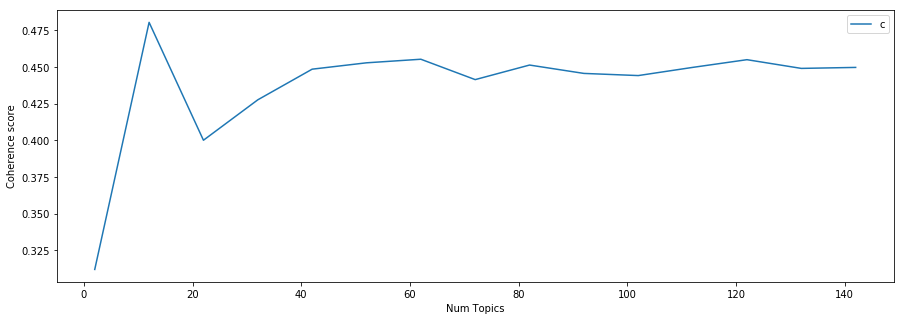

2:  0.31200404625891276
12:  0.4804347373283106
22:  0.4000854448113636
32:  0.4276307765014986
42:  0.4485186170473798
52:  0.4528556476623816
62:  0.45529345961835593
72:  0.44140660994469627
82:  0.45132989526606154
92:  0.4456292067700159
102:  0.4441592759521831
112:  0.44972731975345653
122:  0.4549892504723219
132:  0.44904952107434826
142:  0.44971984514228097


In [384]:
limit=150; start=2; step=10;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

In [386]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=12, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');
print('Time to build model: {} mins'.format(round((time() - t) / 60, 2)))
pprint(lda_model.print_topics())

Time to build model: 0.89 mins
[(0,
  '0.012*"совет" + 0.012*"поддержать" + 0.011*"население" + 0.010*"удалить" + '
  '0.009*"медведев" + 0.009*"прошлое" + 0.009*"обязать" + 0.008*"отец" + '
  '0.007*"исполняться" + 0.007*"подъехать"'),
 (1,
  '0.024*"школа" + 0.016*"решить" + 0.012*"екатеринбург" + 0.010*"помощь" + '
  '0.009*"видео" + 0.008*"фотография" + 0.008*"госдума" + 0.008*"проект" + '
  '0.008*"вид" + 0.007*"потребовать"'),
 (2,
  '0.040*"россия" + 0.021*"сша" + 0.018*"страна" + 0.013*"полицейский" + '
  '0.010*"летний" + 0.010*"объявить" + 0.010*"глава" + 0.008*"заявить" + '
  '0.008*"сообщение" + 0.007*"причина"'),
 (3,
  '0.023*"москва" + 0.015*"полиция" + 0.014*"задержать" + 0.013*"место" + '
  '0.011*"сми" + 0.011*"сообщить" + 0.010*"петербург" + 0.010*"пожар" + '
  '0.009*"результат" + 0.009*"провести"'),
 (4,
  '0.021*"российский" + 0.017*"дело" + 0.013*"суд" + 0.012*"мужчина" + '
  '0.011*"закон" + 0.011*"жизнь" + 0.011*"женщина" + 0.011*"выйти" + '
  '0.010*"запретить

В целом стоп слова можно больше не удалять. Но попробуем убрать еще

Time to count coherence values: 3.87 mins


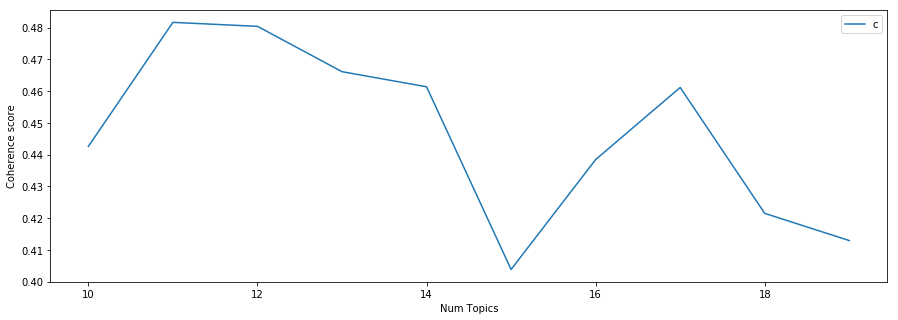

10:  0.4426176769383994
11:  0.48168619241675664
12:  0.4804347373283106
13:  0.46615387964907523
14:  0.46139191838518084
15:  0.40386944097173144
16:  0.4384752877193113
17:  0.46118244501944217
18:  0.42153350212054197
19:  0.4129649774796384


In [387]:
limit=20; start=10; step=1;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

Посмотрим результат на 11 темах:

In [388]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=11, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');
print('Time to build model: {} mins'.format(round((time() - t) / 60, 2)))
pprint(lda_model.print_topics())

Time to build model: 1.96 mins
[(0,
  '0.011*"билет" + 0.010*"поддержать" + 0.009*"apple" + 0.008*"результат '
  'розыгрыш" + 0.007*"оштрафовать" + 0.007*"подробность" + 0.007*"обязать" + '
  '0.006*"остров" + 0.006*"отдать подписчик" + 0.006*"париж"'),
 (1,
  '0.023*"ребёнок" + 0.019*"президент" + 0.014*"школа" + 0.011*"правительство" '
  '+ 0.010*"объявить" + 0.010*"законопроект" + 0.009*"рф" + 0.008*"фотография" '
  '+ 0.007*"госдума" + 0.007*"попросить"'),
 (2,
  '0.016*"мир" + 0.012*"летний" + 0.009*"жить" + 0.008*"умереть" + '
  '0.007*"тысяча" + 0.006*"студент" + 0.006*"территория" + 0.006*"карта" + '
  '0.006*"девочка" + 0.005*"развитие"'),
 (3,
  '0.010*"произойти" + 0.010*"данные" + 0.009*"больница" + 0.009*"взрыв" + '
  '0.009*"сообщать" + 0.008*"находиться" + 0.008*"сервис" + 0.008*"погибший" + '
  '0.007*"вид" + 0.007*"запустить"'),
 (4,
  '0.018*"заявить" + 0.017*"путин" + 0.012*"рубль" + 0.011*"глава" + '
  '0.011*"интернет" + 0.010*"страна" + 0.009*"предложить" + 0.008*

In [389]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.487863905738296

Coherence Score:  0.4593197422419186


Последний результат наиболее правдоподобен. Но попробуем почистить еще

In [390]:
t=time()
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'ows',
                   'который', 'это', 'один', 'главный', 'свой', 'такой', 'лентач', 'ещё', 'еще', 'самый', 'тот', 'пока', 
                   'мол', 'некоторый', 'почему', 'отдельный', 'год', 'неделя', 'сегодня', 'впервые', 'будущий', 'оно',
                  'сразу', 'затем', 'этот', 'также', 'жаль', 'сейчас', 'поэтому', 'лаифкаха', 'ввод', 'вывод', 'broco', 
                   'утро', 'последний', 'то', 'ничто', 'весь', 'стать', 'она', 'дать', 'хороший', 'весь', 'новый', 'имя', 
                   'oqib', 'день', 'хотеть', 'большой', 'наш', 'узнать', 'очень', 'сделаться', 'просто', 'час', 'минута',
                   'назад', 'сюда', 'увеличиться', 'отдельный', 'полностью', 'перестать', 'иметь', 'owyt', 'проходить', 
                   'июль', 'сделать', 'делать', 'читать', 'писать', 'число', 'считать', 'каждый', 'ряд', 'начало', 'конец', 
                   'пикчер', 'ваш', 'любой', 'снова', 'сколько', 'club', 'например', 'лишь', 'целый', 'начать', 
                   'получить', 'com', 'кстати', 'вместо', 'watch', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь',
                    'восемь', 'девять', 'десять','третье', 'мем', 'мема', 'слово', 'пара', 'январь', 'сегодня', 'суббота', 
                   'ждать', 'ru', 'часто', 'тема', 'название', 'вокруг', 'oiahd', 'никто',  'остаться', 'сотня', 'сказать', 
                   'называть', 'предложение', 'представить', 'собираться', 'предложение', 'около', 'нужно', 'сильно', 'вокруг',
                   'именно', 'отправить', 'получать', 'бывший', 'вчера', 'май', 'апрель', 'несколько', 'продолжать', 'март', 
                   'взять', 'пройтись', 'использовать', 'почитать', 'вообще', 'рассказать', 'оказаться', 'rowp', 'ro', 'rrzf', 
                   'никак', 'хотя', 'rreq', 'grace', 'three','ropr', 'практически', 'rrg', 'rofm',
                   'вдвое', 'полтора', 'говориться', 'месяц', 'вечером', 'известный', 'начинать', 'основать', 'слишком',
                   'подвести', 'идти', 'принести', 'distemper', 'внезапно', 'наиболее', 'известный', 'качество', 'являться',
                   'обнаружить', 'in', 'напомнить', 'образовать', 'интересный', 'составить', 'насколько', 'появиться', 'давать',
                   'новое', 'новость', 'найти', 'давно', 'готовый', 
                   'ответ', 'применение', 'кажется', 'готовый', 'новость', 'говорить', 'выглядеть', 'нибыть', 'попытаться',
                   'первое', 'уровень', 'искать', 'сторона', 'удаться', 'выяснить', 'против', 'назвать', 'мочь',
                   'возможность', 'настоящий', 'человек', 'время', 'летний', 'вид', 'прошлое', 'ранее'
                  ])
stop_words = set(stop_words)

morph = pymorphy2.MorphAnalyzer()

data = df.text.values.tolist()
data = [clean(t) for t in data]
data_words = [doc_to_words(text, stop_words, morph) for text in data]

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=1, delimiter=b' ') 
bigram_mod = gensim.models.phrases.Phraser(bigram)    
data_words_bigrams = [bigram_mod[w] for w in data_words]

id2word = corpora.Dictionary(data_words_bigrams) # token to id (add ids to tokens)
corpus = [id2word.doc2bow(text) for text in data_words_bigrams] # create (token_id, token_count): 2-tuples
print('Time to prepare words: {} mins'.format(round((time() - t) / 60, 2)))

Time to prepare words: 0.65 mins


Time to count coherence values: 20.74 mins


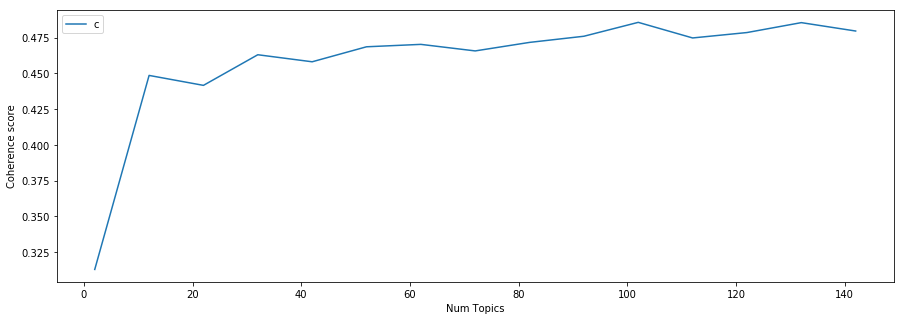

2:  0.31289986940299447
12:  0.44857550004971736
22:  0.44162311994037934
32:  0.4630365567313207
42:  0.4581131777879178
52:  0.46859744356724925
62:  0.4702872807551296
72:  0.46571153099809987
82:  0.47167241352500705
92:  0.4759690018552884
102:  0.48568519212271005
112:  0.47477692930817544
122:  0.47855830467907834
132:  0.4854907149685871
142:  0.47962520448314055


In [391]:
limit=150; start=2; step=10;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

In [394]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=32, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nTime to build model & count scores: {} mins'.format(round((time() - t) / 60, 2)))
print()
pprint(lda_model.print_topics(-1))


Perplexity:  -20.963396529646154

Coherence Score:  0.5100218214100163

Time to build model & count scores: 7.05 mins

[(0,
  '0.048*"пройти" + 0.046*"полицейский" + 0.046*"решить" + 0.041*"митинг" + '
  '0.036*"объявить" + 0.029*"пытаться" + 0.026*"причина" + 0.025*"случай" + '
  '0.015*"арестовать" + 0.015*"многие"'),
 (1,
  '0.054*"сообщение" + 0.034*"угроза" + 0.025*"огонь" + 0.025*"запустить" + '
  '0.019*"бесплатный" + 0.018*"благодаря" + 0.017*"лекция" + 0.015*"авария" + '
  '0.014*"богоматерь" + 0.014*"родственник"'),
 (2,
  '0.048*"мир" + 0.035*"проект" + 0.030*"военный" + 0.025*"создать" + '
  '0.021*"количество" + 0.019*"написать" + 0.018*"задержание" + 0.018*"сергей" '
  '+ 0.018*"поддержать" + 0.017*"победа"'),
 (3,
  '0.062*"группа" + 0.044*"традиционный радиолентач" + 0.038*"закон" + '
  '0.037*"выйти" + 0.024*"музыка" + 0.022*"альбом" + 0.022*"участник" + '
  '0.022*"выпустить" + 0.019*"британский" + 0.019*"поддержка"'),
 (4,
  '0.110*"россиянин" + 0.027*"служба" + 0.0

Продолжим очистку:

In [395]:
t=time()
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'ows',
                   'который', 'это', 'один', 'главный', 'свой', 'такой', 'лентач', 'ещё', 'еще', 'самый', 'тот', 'пока', 
                   'мол', 'некоторый', 'почему', 'отдельный', 'год', 'неделя', 'сегодня', 'впервые', 'будущий', 'оно',
                  'сразу', 'затем', 'этот', 'также', 'жаль', 'сейчас', 'поэтому', 'лаифкаха', 'ввод', 'вывод', 'broco', 
                   'утро', 'последний', 'то', 'ничто', 'весь', 'стать', 'она', 'дать', 'хороший', 'весь', 'новый', 'имя', 
                   'oqib', 'день', 'хотеть', 'большой', 'наш', 'узнать', 'очень', 'сделаться', 'просто', 'час', 'минута',
                   'назад', 'сюда', 'увеличиться', 'отдельный', 'полностью', 'перестать', 'иметь', 'owyt', 'проходить', 
                   'июль', 'сделать', 'делать', 'читать', 'писать', 'число', 'считать', 'каждый', 'ряд', 'начало', 'конец', 
                   'пикчер', 'ваш', 'любой', 'снова', 'сколько', 'club', 'например', 'лишь', 'целый', 'начать', 
                   'получить', 'com', 'кстати', 'вместо', 'watch', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь',
                    'восемь', 'девять', 'десять','третье', 'мем', 'мема', 'слово', 'пара', 'январь', 'сегодня', 'суббота', 
                   'ждать', 'ru', 'часто', 'тема', 'название', 'вокруг', 'oiahd', 'никто',  'остаться', 'сотня', 'сказать', 
                   'называть', 'предложение', 'представить', 'собираться', 'предложение', 'около', 'нужно', 'сильно', 'вокруг',
                   'именно', 'отправить', 'получать', 'бывший', 'вчера', 'май', 'апрель', 'несколько', 'продолжать', 'март', 
                   'взять', 'пройтись', 'использовать', 'почитать', 'вообще', 'рассказать', 'оказаться', 'rowp', 'ro', 'rrzf', 
                   'никак', 'хотя', 'rreq', 'grace', 'three','ropr', 'практически', 'rrg', 'rofm',
                   'вдвое', 'полтора', 'говориться', 'месяц', 'вечером', 'известный', 'начинать', 'основать', 'слишком',
                   'подвести', 'идти', 'принести', 'distemper', 'внезапно', 'наиболее', 'известный', 'качество', 'являться',
                   'обнаружить', 'in', 'напомнить', 'образовать', 'интересный', 'составить', 'насколько', 'появиться', 'давать',
                   'новое', 'новость', 'найти', 'давно', 'готовый', 
                   'ответ', 'применение', 'кажется', 'готовый', 'новость', 'говорить', 'выглядеть', 'нибыть', 'попытаться',
                   'первое', 'уровень', 'искать', 'сторона', 'удаться', 'выяснить', 'против', 'назвать', 'мочь',
                   'возможность', 'настоящий', 'человек', 'время', 'летний', 'вид', 'прошлое', 'ранее',
                   'цель', 'теория', 'смочь', 'однако', 'количество', 'создать', 'многие', 'пытаться', 'минимум', 
                   'вместе', 'тысяча', 'высокий', 'менее', 'цель', 'подробность', 'момент', 'ровно', 'часть', 'недавно', 
                   'знак', 'благодаря', 
#                    'вид', 'прошлое', 'ранее', 'возможность', 'настоящий', 'человек', 'время', 'летний', 'ранее',
#                    'вид', 'прошлое', 'ранее', 'возможность', 'настоящий', 'человек', 'время', 'летний', 'вид', 'прошлое'
                  ])
stop_words = set(stop_words)

morph = pymorphy2.MorphAnalyzer()

data = df.text.values.tolist()
data = [clean(t) for t in data]
data_words = [doc_to_words(text, stop_words, morph) for text in data]

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=1, delimiter=b' ') 
bigram_mod = gensim.models.phrases.Phraser(bigram)    
data_words_bigrams = [bigram_mod[w] for w in data_words]

id2word = corpora.Dictionary(data_words_bigrams) # token to id (add ids to tokens)
corpus = [id2word.doc2bow(text) for text in data_words_bigrams] # create (token_id, token_count): 2-tuples
print('Time to prepare words: {} mins'.format(round((time() - t) / 60, 2)))

Time to prepare words: 0.85 mins


Time to count coherence values: 20.64 mins


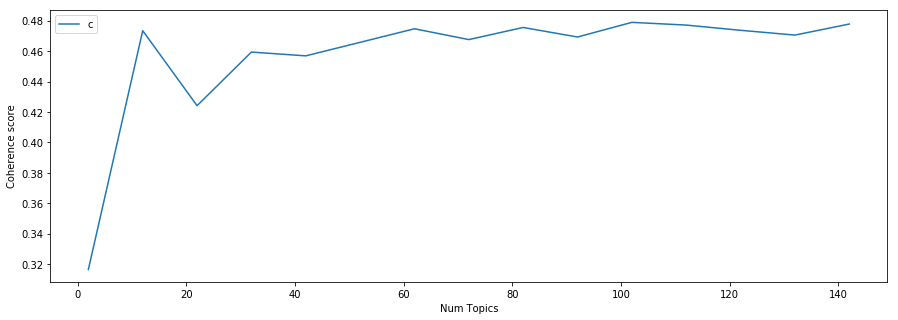

2:  0.3164630032183201
12:  0.4734300281199147
22:  0.42415242854601304
32:  0.45938299886368483
42:  0.4568935360281319
52:  0.46578516917762225
62:  0.4747046305339026
72:  0.46759230973018184
82:  0.47555940966716853
92:  0.46928525825864265
102:  0.4789227530493583
112:  0.47712881523041456
122:  0.47369682721705775
132:  0.470551943681721
142:  0.47781717772839255


In [396]:
limit=150; start=2; step=10;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

In [397]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=12, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nTime to build model & count scores: {} mins'.format(round((time() - t) / 60, 2)))
print()
pprint(lda_model.print_topics(-1))


Perplexity:  -11.54753338912706

Coherence Score:  0.49242406878062295

Time to build model & count scores: 0.98 mins

[(0,
  '0.016*"фильм" + 0.008*"ловить" + 0.008*"совет" + 0.007*"картина" + '
  '0.007*"заблокировать" + 0.007*"сериал" + 0.007*"канал" + 0.007*"план" + '
  '0.006*"серия" + 0.006*"подросток"'),
 (1,
  '0.041*"группа" + 0.029*"традиционный радиолентач" + 0.016*"музыка" + '
  '0.015*"альбом" + 0.013*"американский" + 0.010*"британский" + 0.010*"рок '
  'группа" + 0.007*"робот" + 0.006*"выпустить" + 0.006*"исполняться"'),
 (2,
  '0.018*"москва" + 0.018*"город" + 0.014*"россиянин" + 0.013*"школа" + '
  '0.012*"задержать" + 0.012*"полиция" + 0.012*"сообщить" + 0.010*"область" + '
  '0.010*"место" + 0.010*"полицейский"'),
 (3,
  '0.034*"россия" + 0.017*"российский" + 0.016*"заявить" + 0.015*"власть" + '
  '0.014*"сша" + 0.014*"путин" + 0.014*"страна" + 0.012*"ребёнок" + '
  '0.012*"рубль" + 0.011*"житель"'),
 (4,
  '0.014*"помощь" + 0.013*"говорят" + 0.011*"погибший" + 0.011

In [399]:
t=time()
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'ows',
                   'который', 'это', 'один', 'главный', 'свой', 'такой', 'лентач', 'ещё', 'еще', 'самый', 'тот', 'пока', 
                   'мол', 'некоторый', 'почему', 'отдельный', 'год', 'неделя', 'сегодня', 'впервые', 'будущий', 'оно',
                  'сразу', 'затем', 'этот', 'также', 'жаль', 'сейчас', 'поэтому', 'лаифкаха', 'ввод', 'вывод', 'broco', 
                   'утро', 'последний', 'то', 'ничто', 'весь', 'стать', 'она', 'дать', 'хороший', 'весь', 'новый', 'имя', 
                   'oqib', 'день', 'хотеть', 'большой', 'наш', 'узнать', 'очень', 'сделаться', 'просто', 'час', 'минута',
                   'назад', 'сюда', 'увеличиться', 'отдельный', 'полностью', 'перестать', 'иметь', 'owyt', 'проходить', 
                   'июль', 'сделать', 'делать', 'читать', 'писать', 'число', 'считать', 'каждый', 'ряд', 'начало', 'конец', 
                   'пикчер', 'ваш', 'любой', 'снова', 'сколько', 'club', 'например', 'лишь', 'целый', 'начать', 
                   'получить', 'com', 'кстати', 'вместо', 'watch', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь',
                    'восемь', 'девять', 'десять','третье', 'мем', 'мема', 'слово', 'пара', 'январь', 'сегодня', 'суббота', 
                   'ждать', 'ru', 'часто', 'тема', 'название', 'вокруг', 'oiahd', 'никто',  'остаться', 'сотня', 'сказать', 
                   'называть', 'предложение', 'представить', 'собираться', 'предложение', 'около', 'нужно', 'сильно', 'вокруг',
                   'именно', 'отправить', 'получать', 'бывший', 'вчера', 'май', 'апрель', 'несколько', 'продолжать', 'март', 
                   'взять', 'пройтись', 'использовать', 'почитать', 'вообще', 'рассказать', 'оказаться', 'rowp', 'ro', 'rrzf', 
                   'никак', 'хотя', 'rreq', 'grace', 'three','ropr', 'практически', 'rrg', 'rofm',
                   'вдвое', 'полтора', 'говориться', 'месяц', 'вечером', 'известный', 'начинать', 'основать', 'слишком',
                   'подвести', 'идти', 'принести', 'distemper', 'внезапно', 'наиболее', 'известный', 'качество', 'являться',
                   'обнаружить', 'in', 'напомнить', 'образовать', 'интересный', 'составить', 'насколько', 'появиться', 'давать',
                   'новое', 'новость', 'найти', 'давно', 'готовый', 
                   'ответ', 'применение', 'кажется', 'готовый', 'новость', 'говорить', 'выглядеть', 'нибыть', 'попытаться',
                   'первое', 'уровень', 'искать', 'сторона', 'удаться', 'выяснить', 'против', 'назвать', 'мочь',
                   'возможность', 'настоящий', 'человек', 'время', 'летний', 'вид', 'прошлое', 'ранее',
                   'цель', 'теория', 'смочь', 'однако', 'количество', 'создать', 'многие', 'пытаться', 'минимум', 
                   'вместе', 'тысяча', 'высокий', 'менее', 'цель', 'подробность', 'момент', 'ровно', 'часть', 'недавно', 
                   'знак', 'благодаря', 'важный', 'снег', 'написать', 
#                    'возможность', 'настоящий', 'человек', 'время', 'летний', 'ранее',
#                    'вид', 'прошлое', 'ранее', 'возможность', 'настоящий', 'человек', 'время', 'летний', 'вид', 'прошлое'
                  ])
stop_words = set(stop_words)

morph = pymorphy2.MorphAnalyzer()

data = df.text.values.tolist()
data = [clean(t) for t in data]
data_words = [doc_to_words(text, stop_words, morph) for text in data]

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=1, delimiter=b' ') 
bigram_mod = gensim.models.phrases.Phraser(bigram)    
data_words_bigrams = [bigram_mod[w] for w in data_words]

id2word = corpora.Dictionary(data_words_bigrams) # token to id (add ids to tokens)
corpus = [id2word.doc2bow(text) for text in data_words_bigrams] # create (token_id, token_count): 2-tuples
print('Time to prepare words: {} mins'.format(round((time() - t) / 60, 2)))

Time to prepare words: 0.81 mins


Time to count coherence values: 20.47 mins


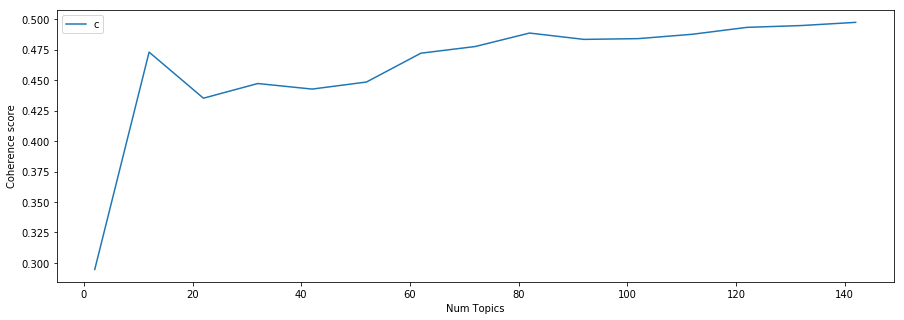

2:  0.29469119445883374
12:  0.4729488069351249
22:  0.4351562335847967
32:  0.4472056213485805
42:  0.442634545729085
52:  0.44844257964905493
62:  0.47207474075055983
72:  0.47754752135543566
82:  0.48860317780034035
92:  0.4834060184766666
102:  0.48402826234562824
112:  0.4876310634221341
122:  0.49327131099411775
132:  0.49475727599495806
142:  0.49737668213657343


In [400]:
limit=150; start=2; step=10;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

In [401]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=82, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nTime to build model & count scores: {} mins'.format(round((time() - t) / 60, 2)))
print()
pprint(lda_model.print_topics(-1))


Perplexity:  -41.315218650749614

Coherence Score:  0.45414055724434993

Time to build model & count scores: 3.07 mins

[(0,
  '0.111*"решить" + 0.044*"территория" + 0.032*"пообещать" + '
  '0.030*"руководство" + 0.027*"состав" + 0.025*"красноярск" + '
  '0.023*"состояться" + 0.022*"автобус" + 0.022*"твой" + 0.020*"одобрить"'),
 (1,
  '0.043*"предлагать" + 0.037*"роскосмос" + 0.035*"приехать" + '
  '0.031*"смотреть" + 0.030*"герой" + 0.027*"канада" + 0.026*"очередь" + '
  '0.025*"вариант" + 0.024*"изменить" + 0.023*"актуальный"'),
 (2,
  '0.063*"улица" + 0.061*"погибший" + 0.054*"ск" + 0.050*"протестовать" + '
  '0.041*"установить" + 0.036*"произойти" + 0.036*"теракт" + 0.030*"продукт" + '
  '0.029*"находиться" + 0.027*"ракета"'),
 (3,
  '0.161*"интернет" + 0.044*"огонь" + 0.044*"спасти" + 0.040*"пожарный" + '
  '0.029*"кредит" + 0.024*"спустя" + 0.022*"утром" + 0.020*"приют" + '
  '0.020*"изменение" + 0.019*"вступить сила"'),
 (4,
  '0.101*"провести" + 0.081*"помощь" + 0.050*"срок" +

И еще один круг:

In [418]:
t=time()
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'ows',
                   'который', 'это', 'один', 'главный', 'свой', 'такой', 'лентач', 'ещё', 'еще', 'самый', 'тот', 'пока', 
                   'мол', 'некоторый', 'почему', 'отдельный', 'год', 'неделя', 'сегодня', 'впервые', 'будущий', 'оно',
                  'сразу', 'затем', 'этот', 'также', 'жаль', 'сейчас', 'поэтому', 'лаифкаха', 'ввод', 'вывод', 'broco', 
                   'утро', 'последний', 'то', 'ничто', 'весь', 'стать', 'она', 'дать', 'хороший', 'весь', 'новый', 'имя', 
                   'oqib', 'день', 'хотеть', 'большой', 'наш', 'узнать', 'очень', 'сделаться', 'просто', 'час', 'минута',
                   'назад', 'сюда', 'увеличиться', 'отдельный', 'полностью', 'перестать', 'иметь', 'owyt', 'проходить', 
                   'июль', 'сделать', 'делать', 'читать', 'писать', 'число', 'считать', 'каждый', 'ряд', 'начало', 'конец', 
                   'пикчер', 'ваш', 'любой', 'снова', 'сколько', 'club', 'например', 'лишь', 'целый', 'начать', 
                   'получить', 'com', 'кстати', 'вместо', 'watch', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь',
                    'восемь', 'девять', 'десять','третье', 'мем', 'мема', 'слово', 'пара', 'январь', 'сегодня', 'суббота', 
                   'ждать', 'ru', 'часто', 'тема', 'название', 'вокруг', 'oiahd', 'никто',  'остаться', 'сотня', 'сказать', 
                   'называть', 'предложение', 'представить', 'собираться', 'предложение', 'около', 'нужно', 'сильно', 'вокруг',
                   'именно', 'отправить', 'получать', 'бывший', 'вчера', 'май', 'апрель', 'несколько', 'продолжать', 'март', 
                   'взять', 'пройтись', 'использовать', 'почитать', 'вообще', 'рассказать', 'оказаться', 'rowp', 'ro', 'rrzf', 
                   'никак', 'хотя', 'rreq', 'grace', 'three','ropr', 'практически', 'rrg', 'rofm',
                   'вдвое', 'полтора', 'говориться', 'месяц', 'вечером', 'известный', 'начинать', 'основать', 'слишком',
                   'подвести', 'идти', 'принести', 'distemper', 'внезапно', 'наиболее', 'известный', 'качество', 'являться',
                   'обнаружить', 'in', 'напомнить', 'образовать', 'интересный', 'составить', 'насколько', 'появиться', 'давать',
                   'новое', 'новость', 'найти', 'давно', 'готовый', 'продолжаться',
                   'ответ', 'применение', 'кажется', 'готовый', 'новость', 'говорить', 'выглядеть', 'нибыть', 'попытаться',
                   'первое', 'уровень', 'искать', 'сторона', 'удаться', 'выяснить', 'против', 'назвать', 'мочь',
                   'возможность', 'настоящий', 'человек', 'время', 'летний', 'вид', 'прошлое', 'ранее',
                   'цель', 'теория', 'смочь', 'однако', 'количество', 'создать', 'многие', 'пытаться', 'минимум', 
                   'вместе', 'тысяча', 'высокий', 'менее', 'цель', 'подробность', 'момент', 'ровно', 'часть', 'недавно', 
                   'знак', 'благодаря', 'важный', 'снег', 'написать', 
                   'твой', 'вариант', 'изменить', 'очередь', 'актуальный', 'зимний', 'второе', 'set up', 'включая',
                   'олд', 'оба', 'итог', 'век', 'среди', 'говорят', 'простой', 'таки', 'вопрос', 'никакой', 'немного',
                   'спасибо', 'единственный', 'добавить', 'вовсе', 'попасть', 'строить', 'крутой', 'идея', 'вырасти', 
                   'рост', 'ребята', 'часы', 'ночь', 'правило', 'вид'
                  ])
stop_words = set(stop_words)

morph = pymorphy2.MorphAnalyzer()

data = df.text.values.tolist()
data = [clean(t) for t in data]
data_words = [doc_to_words(text, stop_words, morph) for text in data]

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=1, delimiter=b' ') 
bigram_mod = gensim.models.phrases.Phraser(bigram)    
data_words_bigrams = [bigram_mod[w] for w in data_words]

id2word = corpora.Dictionary(data_words_bigrams) # token to id (add ids to tokens)
corpus = [id2word.doc2bow(text) for text in data_words_bigrams] # create (token_id, token_count): 2-tuples
print('Time to prepare words: {} mins'.format(round((time() - t) / 60, 2)))

Time to prepare words: 0.76 mins


Time to count coherence values: 21.04 mins


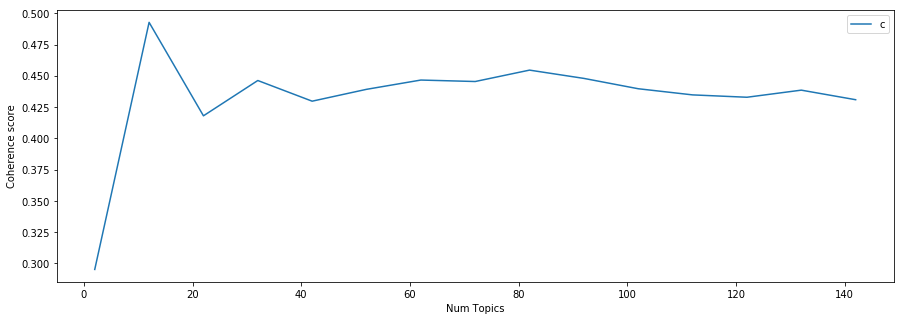

2:  0.29515312372880653
12:  0.4927188966895025
22:  0.41798998986827113
32:  0.4462201561756173
42:  0.42969253314084677
52:  0.4391669602907587
62:  0.4465859421457192
72:  0.44541580552879584
82:  0.454529381746597
92:  0.44790382404140616
102:  0.43963606653859044
112:  0.4347238772255261
122:  0.432835938447884
132:  0.43851397972169004
142:  0.43086593393638106


In [419]:
limit=150; start=2; step=10;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

Time to count coherence values: 3.96 mins


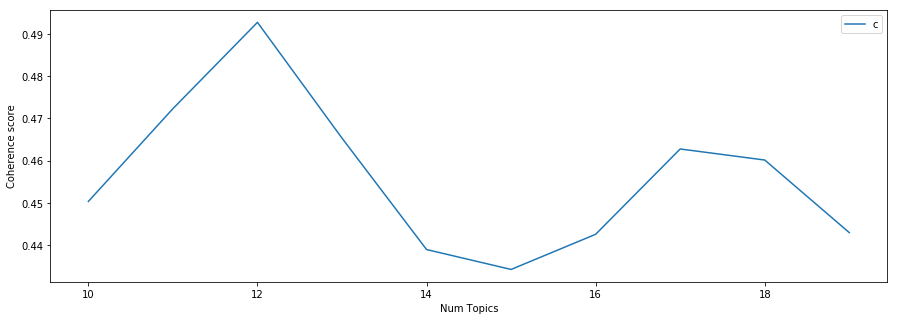

10:  0.4503534864393378
11:  0.47229857222213584
12:  0.4927188966895025
13:  0.4653222701705061
14:  0.43897099055543
15:  0.434260099271652
16:  0.4425750255566634
17:  0.4627622913921345
18:  0.46014659151536197
19:  0.44297539938789793


In [422]:
limit=20; start=10; step=1;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

Time to count coherence values: 5.49 mins


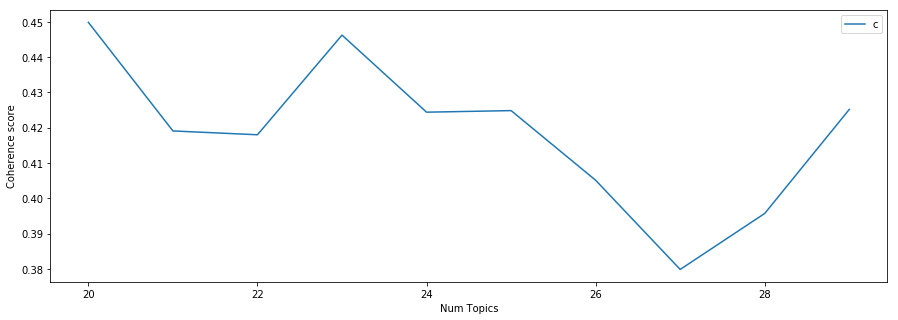

20:  0.44984596847320935
21:  0.4190731014926349
22:  0.41798998986827113
23:  0.4462346530463248
24:  0.4243911651085335
25:  0.4248375713677836
26:  0.40510100419003925
27:  0.37982388637216047
28:  0.3956974618538318
29:  0.4251748678693677


In [425]:
limit=30; start=20; step=1;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words_bigrams, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

In [426]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=23, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nTime to build model & count scores: {} mins'.format(round((time() - t) / 60, 2)))
print()
pprint(lda_model.print_topics(-1))


Perplexity:  -17.697035945835804

Coherence Score:  0.5068050964576534

Time to build model & count scores: 1.16 mins

[(0,
  '0.051*"московский" + 0.030*"мвд" + 0.029*"лидер" + 0.025*"активист" + '
  '0.018*"республика" + 0.017*"партия" + 0.017*"прислать" + 0.016*"уйти" + '
  '0.013*"ранний" + 0.013*"приговорить"'),
 (1,
  '0.073*"группа" + 0.052*"традиционный радиолентач" + 0.040*"американский" + '
  '0.026*"альбом" + 0.025*"выпустить" + 0.022*"британский" + 0.018*"рок '
  'группа" + 0.017*"миллион" + 0.016*"установить" + 0.015*"китайский"'),
 (2,
  '0.053*"история" + 0.041*"учёный" + 0.033*"проект" + 0.023*"умереть" + '
  '0.018*"доллар" + 0.018*"ловить" + 0.017*"концерт" + 0.017*"рассказывать" + '
  '0.016*"земля" + 0.015*"фсб"'),
 (3,
  '0.041*"сотрудник" + 0.020*"школьник" + 0.020*"врач" + 0.020*"ск" + '
  '0.018*"документ" + 0.017*"проверка" + 0.017*"навальный" + 0.015*"план" + '
  '0.014*"праздник" + 0.013*"приехать"'),
 (4,
  '0.059*"самолёт" + 0.028*"лицо" + 0.021*"борт" + 0

In [424]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=12, 
        random_state=100,
        update_every=1,
        chunksize=500,
        passes=50,
        alpha='auto');

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nTime to build model & count scores: {} mins'.format(round((time() - t) / 60, 2)))
print()
pprint(lda_model.print_topics(-1))


Perplexity:  -11.576040354332896

Coherence Score:  0.4645568392405642

Time to build model & count scores: 0.96 mins

[(0,
  '0.014*"администрация" + 0.011*"снять" + 0.009*"мусор" + 0.009*"образ" + '
  '0.008*"фестиваль" + 0.007*"общий" + 0.006*"килограмм" + 0.006*"бесплатный" '
  '+ 0.006*"уволить" + 0.006*"лекция"'),
 (1,
  '0.012*"актёр" + 0.012*"продолжаться" + 0.011*"сериал" + 0.011*"установить" '
  '+ 0.010*"губернатор" + 0.010*"серия" + 0.009*"завод" + 0.009*"заявление" + '
  '0.009*"уйти" + 0.008*"строительство храм"'),
 (2,
  '0.019*"дело" + 0.019*"задержать" + 0.014*"сотрудник" + 0.010*"рф" + '
  '0.008*"полицейский" + 0.008*"умереть" + 0.008*"нарушение" + '
  '0.007*"журналист" + 0.007*"помочь" + 0.007*"проблема"'),
 (3,
  '0.021*"город" + 0.020*"власть" + 0.017*"школа" + 0.015*"сми" + '
  '0.014*"полиция" + 0.014*"сообщить" + 0.013*"интернет" + 0.012*"область" + '
  '0.011*"самолёт" + 0.010*"здание"'),
 (4,
  '0.023*"мужчина" + 0.020*"женщина" + 0.011*"разрешить" + 0.009*